In [1]:
from experiments.partial import build_partial, plot_partial
from lafomo.datasets import DrosophilaSpatialTranscriptomics, ToySpatialTranscriptomics
from lafomo.models import MultiOutputGP
from matplotlib import pyplot as plt
import torch
from lafomo.configuration import VariationalConfiguration

In [2]:
# dataset = DrosophilaSpatialTranscriptomics(gene='kr', data_dir='../../../data')
dataset = ToySpatialTranscriptomics(data_dir='../../../data')
data = 'dros-kr'
data = 'toy-spatial'
params = dict(lengthscale=10,
              sensitivity=0.1,
              decay=0.05,
              diffusion=0.001,
              natural=True,
              clamp=True)
lfm, trainer, plotter = build_partial(
    dataset,
    params,
    reload=f'../../../experiments/{data}/partial/0savedmodel')

t_sorted, dp [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ] 0.025
x dp is set to 0.025
t_sorted, dp [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ] 0.025


In [3]:
data = next(iter(trainer.data_loader))
t = data[0][0]
y = data[1][0]
print(y.shape, t.shape)

torch.Size([1, 1681]) torch.Size([2, 1681])


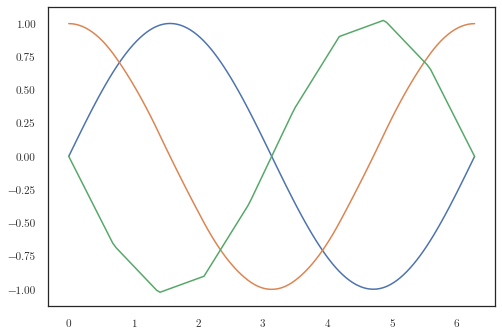

In [4]:
from torchcubicspline import(natural_cubic_spline_coeffs,
                             NaturalCubicSpline)

def calc(N, d):
    return (N - 1) * (d + 1) + 1

def spline_interpolate_gradient(x, y, num_disc=9):
    """
    Returns x_interpolate, y_interpolate, y_grad, y_grad_2: the interpolated time, data and gradient
    """
    x_interpolate = torch.linspace(torch.min(x), torch.max(x), calc(13, num_disc))
    coeffs = natural_cubic_spline_coeffs(x, y)
    spline = NaturalCubicSpline(coeffs)
    y_interpolate = spline.evaluate(x_interpolate)
    y_grad = spline.derivative(x_interpolate) #y_interpolate, denom, axis=1)
    y_grad_2 = spline.derivative(x_interpolate, order=2)
    return x_interpolate, y_interpolate, y_grad, y_grad_2

In [ ]:
t_interpolate, y_interpolate, y_grad = spline_interpolate_gradient(t, data[1])#.permute(1, 0))
y_grad_target = y_grad[:, ::9][:, ::2]
t_target = torch.tensor(t_interpolate[::9])[::2]
plt.plot(x_interpolate, y_interpolate[:, 0])
plt.plot(x_interpolate, y_grad[:, 0])
plt.plot(x_interpolate, y_grad_2[:, 0])

def pde_func(y, u, sensitivity, decay, diffusion):
    print(y.shape, u.shape, sensitivity.shape)
    return sensitivity * u - decay * y

Mean output variance: 2.0151256101480586
Test loss: 190.98487489702595
Q2: 0.120
Epoch 071/080 - Loss: 75.40 (71.34 4.06) kernel: [[[9.01165965]]] s: 0.10571546226232088 dec: 0.004601254856113355 diff: 0.007397358336912451
Mean output variance: 2.2906805111840174
Test loss: 187.38157652362744
Q2: 0.130
Epoch 072/080 - Loss: 74.12 (70.04 4.08) kernel: [[[9.01102587]]] s: 0.10570366738454855 dec: 0.004530536907366705 diff: 0.007274535445018245
Mean output variance: 2.258217860689423
Test loss: 186.21601769679646
Q2: 0.129
Epoch 073/080 - Loss: 73.73 (69.64 4.09) kernel: [[[9.00801091]]] s: 0.10568817984983905 dec: 0.004462528600031907 diff: 0.007156474319311407
Mean output variance: 1.8126813686840797
Test loss: 186.05805421220995
Q2: 0.124
Epoch 074/080 - Loss: 73.61 (69.51 4.10) kernel: [[[9.00469585]]] s: 0.10567027154066831 dec: 0.0043970442681788 diff: 0.0070428848815509305
Mean output variance: 2.0236596334908405
Test loss: 182.30828828363582
Q2: 0.136
Epoch 075/080 - Loss: 72.23 (

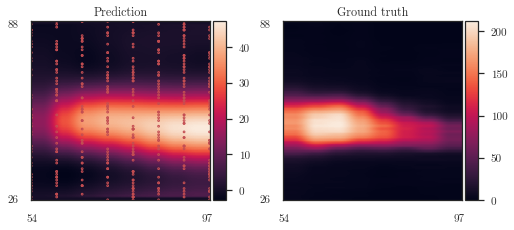

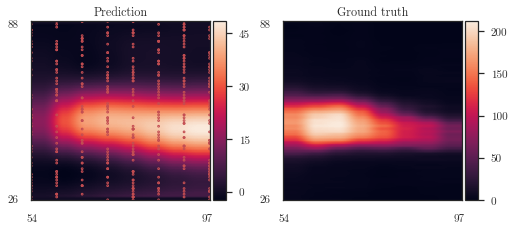

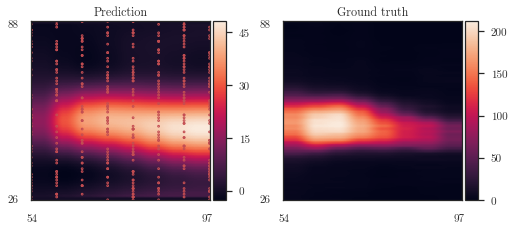

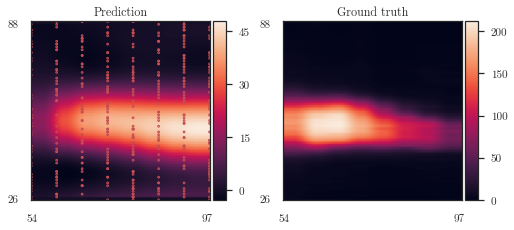

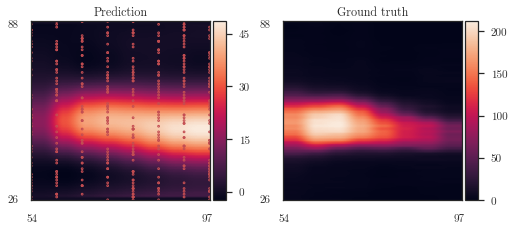

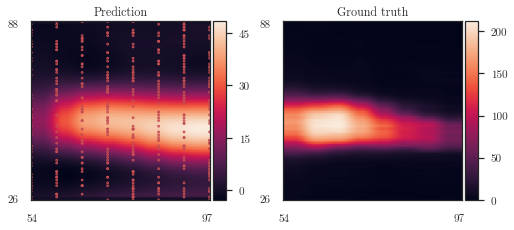

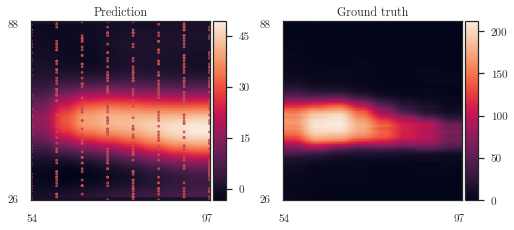

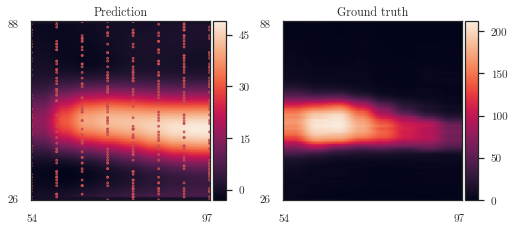

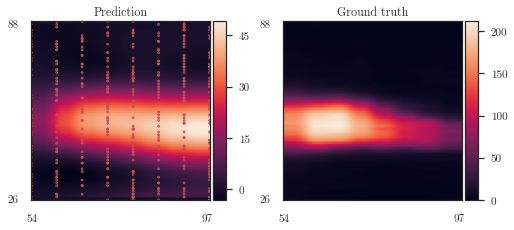

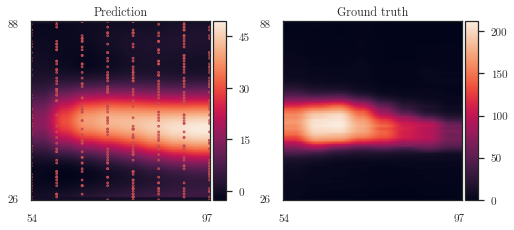

In [46]:
lfm.pretrain(True)
trainer.train(10)

In [ ]:
lfm.pretrain(False)
trainer.train(10)

In [6]:
from matplotlib import pyplot as plt
plt.imshow(dict(lfm.named_parameters())['gp_model.variational_strategy.base_variational_strategy._variational_distribution.natural_tril_mat'][0].detach())
plt.colorbar()

KeyError: 'gp_model.variational_strategy.base_variational_strategy._variational_distribution.natural_tril_mat'

In [11]:
from lafomo.utilities.torch import softplus
print(list(map(softplus, lfm.fenics_parameters)))

[tensor([[1.5704]], dtype=torch.float64), tensor([[0.0604]], dtype=torch.float64), tensor([[0.1018]], dtype=torch.float64)]


'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


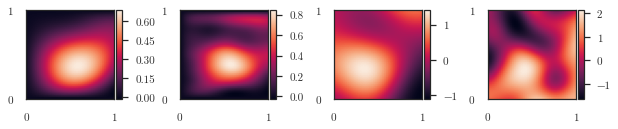

In [6]:
from pathlib import Path
plot_partial(dataset, lfm, trainer, plotter, Path('./'), params)

torch.Size([512, 1])


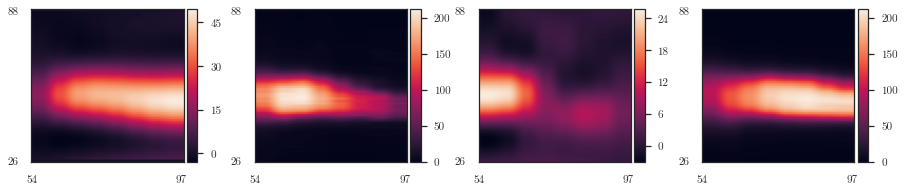

In [49]:
from lafomo.plot import plot_spatiotemporal_data
lfm.eval()
tx = trainer.tx
num_t = tx[0, :].unique().shape[0]
num_x = tx[1, :].unique().shape[0]
f = lfm(tx)
f_mean = f.mean.detach()
f_var = f.variance.detach()
y_target = trainer.y_target[0]
ts = tx[0, :].unique().sort()[0].numpy()
xs = tx[1, :].unique().sort()[0].numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]

# print(dataset.orig_data[:, 2])
l_target = torch.tensor(dataset.orig_data[:, 2])
l = lfm.gp_model(tx.t())
l_mean = l.mean.detach()
# plt.imshow(l_mean.view(num_t, num_x).transpose(0, 1))
print(l_mean.shape)
plot_spatiotemporal_data(
    [
        f_mean.view(num_t, num_x).t(),
        y_target.view(num_t, num_x).detach().t(),

        l_mean.view(num_t, num_x).t(),
        l_target.view(num_t, num_x).t()
    ],
    extent,
    titles=None
)
plt.gca().get_figure().set_size_inches(15, 7)

None


/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/matplotlib/tight_bbox.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/matplotlib/tight_bbox.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/matplotlib/patches.py:778: RuntimeWarning: invalid value encountered in double_scalars
  self._x1 = self._x0 + self._width
/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/matplotlib/transforms.py:1977: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[0, 2] += tx


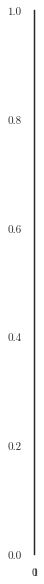

AxesSubplot(0.125,0.125;0.775x0.755)


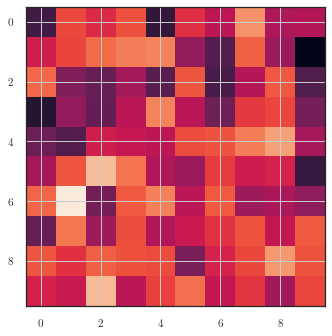

In [17]:
import torch
fig, ax = plt.subplots()
ax.imshow(torch.randn(10, 10))
ax.grid()
print(ax)